## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [3]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [4]:
train, test = keras.datasets.cifar10.load_data()

In [5]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [6]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [10]:
from keras.layers import Input, Dense, BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = Dense(units = n_units, activation='relu', name='hidden_layer%d'%(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = Dense(units = n_units, activation='relu', name='hidden_layer%d'%(i+1))(x)
            x = BatchNormalization()(x)
    
    output_layer = Dense(units=output_units, activation='softmax', name='output_layer')(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])
    return model

In [1]:
# Hyperparams
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
PATIENCE = [10, 25]

In [12]:
# 載入 Callbacks
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='val_accuracy',
                         patience=5,
                         verbose=1)

results = {}
for p in PATIENCE:
    keras.backend.clear_session()
    print('Experiment with patience %d'%p)
    
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    model.fit(x_train, y_train,
             epochs=EPOCHS,
             batch_size=BATCH_SIZE,
             validation_data=(x_test, y_test),
             shuffle=True,
             callbacks=[earlystop])
    
    exp_name_tag = 'patience = %d'%p
    results[exp_name_tag] = {'train_loss': model.history.history['loss'],
                            'valid_loss': model.history.history['val_loss'],
                            'train_acc': model.history.history['accuracy'],
                            'valid_acc': model.history.history['val_accuracy']}

Experiment with patience 10
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (N

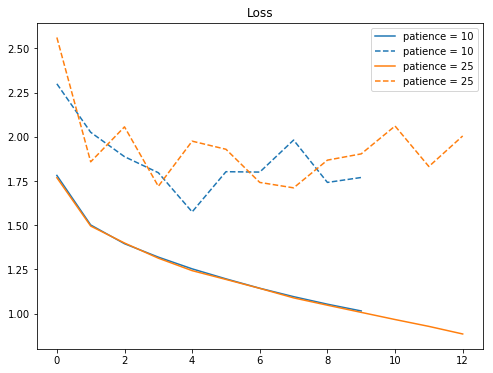

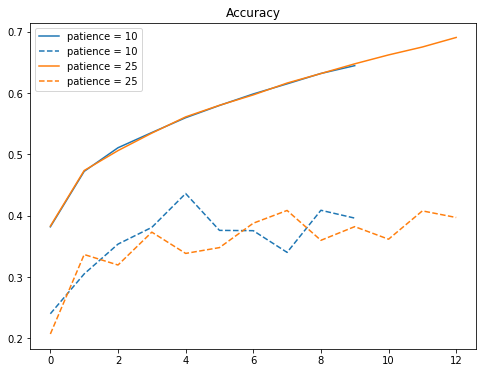

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ['C0', 'C1']

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_loss'])), results[cond]['train_loss'], '-', color=color_bar[i], label=cond)
    plt.plot(range(len(results[cond]['valid_loss'])), results[cond]['valid_loss'], '--', color=color_bar[i], label=cond)
plt.title('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_acc'])), results[cond]['train_acc'], '-', color=color_bar[i], label=cond)
    plt.plot(range(len(results[cond]['valid_acc'])), results[cond]['valid_acc'], '--', color=color_bar[i], label=cond)
plt.title('Accuracy')
plt.legend()
plt.show()